In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator, CubicSpline, make_interp_spline
import numpy as np
import cvxpy as cp

In [2]:
def combine_parity(row):
    if pd.notna(row['call_parity']):
        return row['call_parity']
    else:
        return row['put_parity']

def filter_ref_price(row):
    call_last = row['call_last_price']
    put_last = row['put_last_price']
    parity = row['parity']
    ask = row['call_ask']
    mid = row['call_mid']
    bid = row['call_bid']
    plb = row['call_plb']  # price lower bound: bs_price where sigma->0

    if pd.notna(call_last):
        if bid < call_last < ask:
            return call_last
        elif ask < call_last:
                return ask
        elif call_last < bid:
            if bid <= plb: # bid spread exceeds the lower bound
                return plb
            else:
                return bid

    if pd.notna(put_last):
        parity_call = put_last + parity
        if bid < parity_call < ask:
            return parity_call
        elif ask < parity_call:
            return ask
        elif parity_call < bid:
            if bid <= plb:
                return plb
            else:
                return bid

    return mid

cols = ['K', 'parity', 'plb', 'best_price', 'ask', 'mid', 'bid', 'last_price']

call = pd.read_csv('data/call_041125_051625.csv')
put = pd.read_csv('data/put_20250411_051625.csv')
call = call.reset_index()
put = put.reset_index()

call = call.rename(columns={col: f'call_{col}' for col in call.columns if col != 'K'})
put = put.rename(columns={col: f'put_{col}' for col in put.columns if col != 'K'})
df = pd.merge(call, put, on='K', how='outer')
df.set_index('K', inplace=True)

df['parity'] = df.apply(combine_parity, axis=1)
df['ref_price'] = df.apply(filter_ref_price, axis=1)

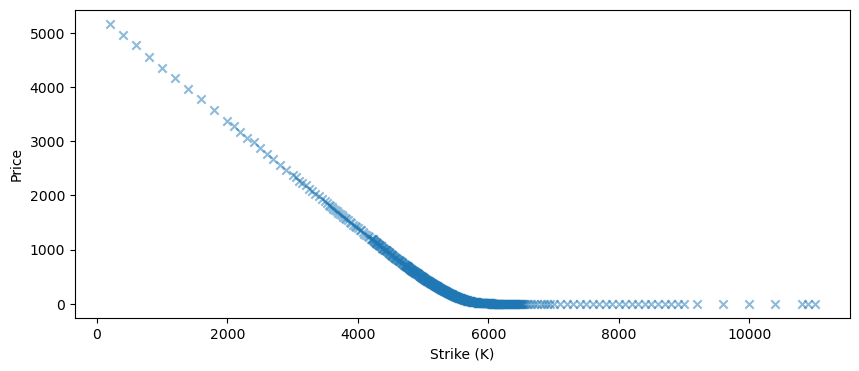

In [3]:
plt.figure(figsize=(10, 4))
plt.scatter(df.index, df['ref_price'], marker='x', alpha=0.5)
plt.ylabel('Price')
plt.xlabel('Strike (K)')
plt.show()

# Risk-neutral probability distribution

### Methodology for Estimating Market Probability Density Functions 

#### Steps
1. (data source) Collected daily S&P 500 option data (SPX) across all strike prices traded (volume > 0) that expire approximately a month later from Bloomberg. This is both an index and European style option.
2. (day count convention) Used Act/365 day count convention so that the time to maturity is the remaining days up to the maturity over 365
3. (interest rate) Associated a risk-free rate with each option based on an interpolation of the risk-free yield curve from Bloomberg that existed on the specific price date. I used a convex monotone interpolation method to match the time to expiration of each option and express each value as a continuously compounded interest rate. 
4. (dividend yield) implied dividend yield curve? DIVD 
5. (put data) all put options are transformed into call option prices using the put-call parity $C=P+Se^{-q*\tau}-Ke^{-r*\tau}$ where q and r is continuously compounded dividend yield and interest rate respectively.
6. (implied volatility) applied brent q root finding algorithm for standard Black-Scholes model, considering a dividend yield to find implied volatility of each option. I eliminated (treat as NaN) all observations where call option price does not permit an implied volatility to be calculated.
7. Next, we condense the data set by selecting a single option at each strike price. If multiple
observations are present, we choose the most recent price date and give primacy to call
options over transformed put options if the strike price is greater than the current spot price
(when the strike price is below the current spot price we give primacy to transformed put
options). In essence, we treat the five-day period as if it were a single trading day and select
the “last price” at each strike. 
8. We then fit a cubic B-spline smooth to the [strike price, implied volatility] pairs, interpolate
several hundred implied volatilities between the minimum and maximum strike prices, and
use the interpolated values to calculate call option prices using the model specified in step 5.
Note that we use as inputs to the model the value of the spot price, risk-free rate, dividend
yield, and time to expiration at the end of the five-day window. We use the first and last
estimated spline segments to extrapolate beyond the minimum and maximum strike prices
present in our data set. The resulting [strike price, call price] observations serve as our proxy
for the continuous call price function. 
9. The first and second derivatives of the proxy call price function are estimated numerically,
and the values of the second derivative are divided by $e^{-r\tau}$. The result is the market
probability density function (MPD) implied by the options market for the future value of the
S&P 500 Index. 
10. Lastly, we convert the MPD from “price space” into “log return space” via the standard
change-of-variable transformation. 

##### References
1. Breeden, D. T., and Litzenberger, R. H. (1978), “Prices of state-contingent claims implicit in option
prices,” Journal of Business 51 (4), pp. 621-51.
2. Shimko, D. C. (1993), “Bounds of Probability,” Risk, 6 (4), pp. 33-37. 
3. FEDERAL RESERVE BANK OF MINNEAPOLIS
4. Jackwerth(2000)

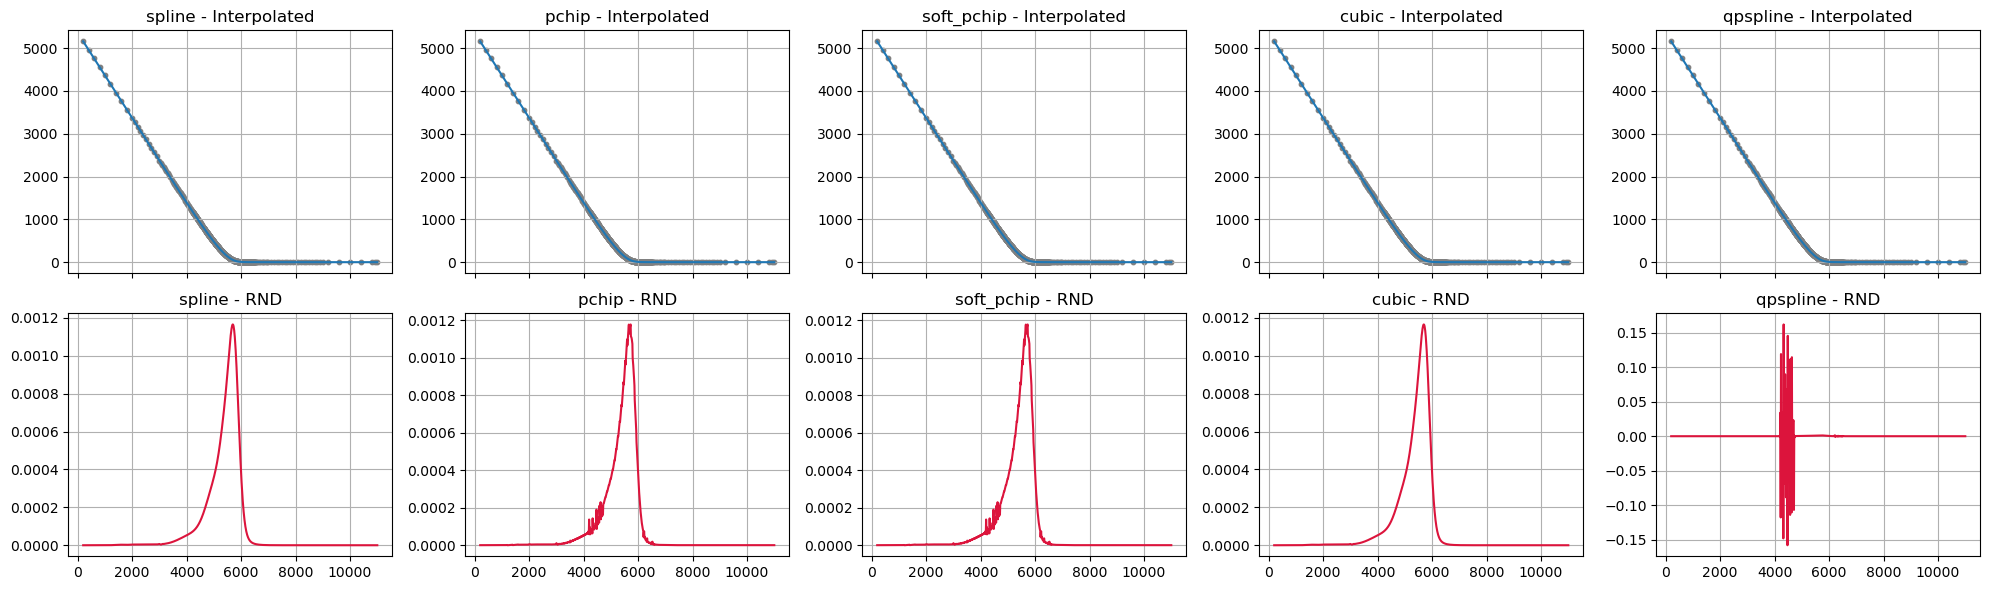

In [53]:
r = call['call_r'].iloc[0]
T = call['call_T'].iloc[0]
K_dense = np.linspace(df.index.min(), df.index.max(), 1000)
x = df.index.values
y_orig = df['call_bs_thr_iv'].values

def compute_RND(x, y, kind='spline'):
    if kind == 'pchip':
        interp = PchipInterpolator(x, y)
    elif kind == 'soft_pchip':
        y_adjusted = np.where(y < 0, 0, y)  # soft adjustment: clip negative
        interp = PchipInterpolator(x, y_adjusted)
    elif kind == 'cubic':
        interp = CubicSpline(x, y, bc_type='natural')
    elif kind == 'spline':
        interp = make_interp_spline(x, y, k=3)
    elif kind == 'qpspline':
        # Convex-constrained quadratic program
        n = len(x)
        f = cp.Variable(n)
        objective = cp.Minimize(cp.sum_squares(f - y))
        constraints = [f[i - 1] - 2 * f[i] + f[i + 1] >= 0 for i in range(1, n - 1)]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.ECOS)
        interp = CubicSpline(x, f.value, bc_type='natural')
    else:
        raise ValueError("Unknown interpolation type")

    y_dense = interp(K_dense)
    d2 = interp(K_dense, 2)
    RND = np.exp(-r * T) * d2
    return RND, y_dense

# ---- 5가지 방법 모두 실행 ----
methods = ['spline', 'pchip', 'soft_pchip', 'cubic', 'qpspline']
results = {}
for method in methods:
    RND, y_interp = compute_RND(x, y_orig, kind=method)
    results[method] = (RND, y_interp)

# ---- 그래프 시각화 및 저장 ----
fig, axes = plt.subplots(2, len(methods), figsize=(4*len(methods), 6), sharex=True)
for i, method in enumerate(methods):
    rnd, y_interp = results[method]
    axes[0, i].plot(K_dense, y_interp, label=method)
    axes[0, i].scatter(x, y_orig, color='gray', s=10)
    axes[0, i].set_title(f"{method} - Interpolated")
    axes[1, i].plot(K_dense, rnd, label='RND', color='crimson')
    axes[1, i].set_title(f"{method} - RND")
    axes[0, i].grid(True)
    axes[1, i].grid(True)

plt.tight_layout()
plt.savefig("RND_comparison.png", dpi=300)
plt.show()

In this case, the curve dosen't need to through each point since they were the best estimator of traded prices. So, I estimated a curve that ensure convexity and represent the data points best using convex optimization.

In [79]:
!pip show ecos

Name: ecos
Version: 2.0.14
Summary: This is the Python package for ECOS: Embedded Cone Solver. See Github page for more information.
Home-page: http://github.com/embotech/ecos
Author: Alexander Domahidi, Eric Chu, Han Wang, Santiago Akle
Author-email: domahidi@embotech.com, echu@cs.stanford.edu, hanwang2@stanford.edu, tiagoakle@gmail.com
License: GPLv3
Location: /opt/anaconda3/lib/python3.12/site-packages
Requires: numpy, scipy
Required-by: 


In [47]:
import numpy as np
import cvxpy as cp
from scipy.interpolate import make_interp_spline, CubicSpline
import matplotlib.pyplot as plt

def compute_numerical_second_derivative(f_vals: np.ndarray, K_vals: np.ndarray) -> np.ndarray:
    d2f = np.zeros_like(f_vals)
    h = K_vals[1] - K_vals[0]  # assumes uniform spacing
    for i in range(1, len(f_vals) - 1):
        d2f[i] = (f_vals[i + 1] - 2 * f_vals[i] + f_vals[i - 1]) / (h ** 2)
    d2f[0] = d2f[1]
    d2f[-1] = d2f[-2]
    return d2f

def fit_spline_then_convex_RND(K: np.ndarray, prices: np.ndarray, S: float, r: float, T: float,
                                num_dense_points: int = 500, save_path: str = None, show_plot: bool = True):
    """
    Full pipeline:
    - Smooth option prices with B-spline
    - Fit convex + intrinsic-above envelope on spline-smoothed curve
    - Compute RND from final convex curve using central difference

    Parameters:
    - K: strike prices (1D array)
    - prices: option prices (1D array)
    - S: underlying asset price
    - r: risk-free rate
    - T: time to maturity (in years)
    - num_dense_points: number of K grid points after smoothing
    - save_path: optional path to save plots
    - show_plot: display plots if True

    Returns:
    - f_convex_dense: final convex price curve
    - RND: estimated risk-neutral density
    - K_dense: dense K grid used
    """
    # Step 0: Sort input
    sort_idx = np.argsort(K)
    K = np.array(K)[sort_idx]
    prices = np.array(prices)[sort_idx]
    intrinsic = np.maximum(S - K, 0)

    # Step 1: B-spline smoothing
    spline = make_interp_spline(K, prices, k=3)
    K_dense = np.linspace(K.min(), K.max(), num_dense_points)
    price_smooth_dense = spline(K_dense)
    intrinsic_dense = np.maximum(S - K_dense, 0)

    # Step 2: Convex + intrinsic optimization
    n = len(K_dense)
    f = cp.Variable(n)
    objective = cp.Minimize(cp.sum_squares(f - price_smooth_dense))
    constraints = []
    
    # ① Convexity constraint: f'' ≥ 0
    constraints += [f[i - 1] - 2 * f[i] + f[i + 1] >= 0 for i in range(1, n - 1)]
    
    # ② Smooth convexity: Δ²f 변화량 제한
    epsilon = 0.0005  # 허용되는 convexity 변화량, 조절 가능
    for i in range(2, n - 2):
        d2_prev = f[i - 1] - 2 * f[i] + f[i + 1]
        d2_next = f[i] - 2 * f[i + 1] + f[i + 2]
        constraints.append(cp.abs(d2_next - d2_prev) <= epsilon)
    
    # ③ Intrinsic value constraint
    constraints += [f[i] >= intrinsic_dense[i] for i in range(n)]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.ECOS)

    f_convex_dense = f.value

    # Step 3: Numerical 2nd derivative for RND
    d2f_dense = compute_numerical_second_derivative(f_convex_dense, K_dense)
    RND = np.exp(-r * T) * d2f_dense

    # Step 4: Visualization
    if show_plot or save_path:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        ax1.plot(K, prices, 'o', color='gray', label='Observed Prices')
        ax1.plot(K_dense, price_smooth_dense, '--', label='Spline Smoothed', color='blue')
        ax1.plot(K_dense, f_convex_dense, label='Convex Fit', color='red')
        ax1.plot(K_dense, intrinsic_dense, '--', label='Intrinsic Value', color='black')
        ax1.fill_between(K_dense, intrinsic_dense, f_convex_dense, color='pink', alpha=0.2)
        ax1.set_title("Convex Fit above Spline + Intrinsic")
        ax1.set_xlabel("Strike (K)")
        ax1.set_ylabel("Option Price")
        ax1.grid(True)
        ax1.legend()

        ax2.plot(K_dense, RND, label='RND', color='crimson')
        ax2.axhline(0, linestyle='--', color='gray')
        ax2.set_title("Estimated Risk-Neutral Density")
        ax2.set_xlabel("Strike (K)")
        ax2.set_ylabel("Density")
        ax2.grid(True)
        ax2.legend()

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300)
        if show_plot:
            plt.show()
        else:
            plt.close()

    return f_convex_dense, RND, K_dense

/opt/anaconda3/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


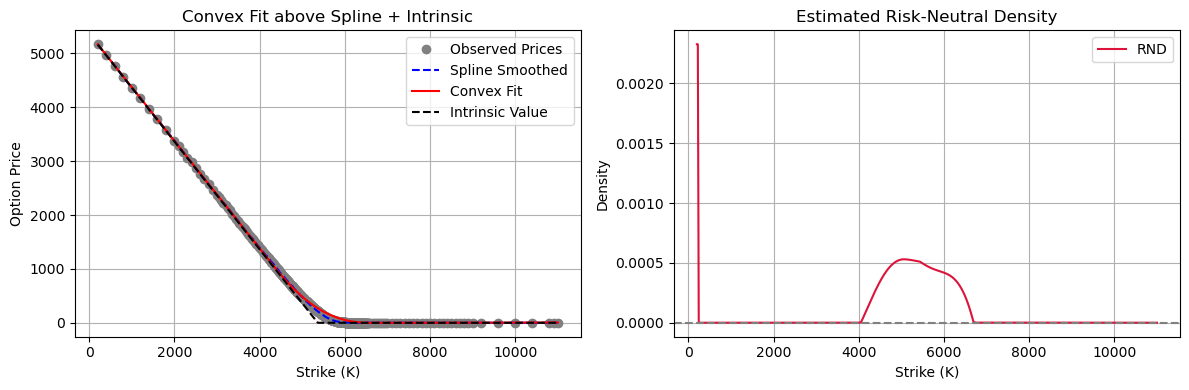

In [48]:
# 샘플 데이터
K = df.index.values
S = call['call_S'].iloc[0]
prices = df['ref_price'].values
r = call['call_r'].iloc[0]
T = call['call_T'].iloc[0]

# 실행
spline_convex, RND, K_dense = fit_spline_then_convex_RND(
    K=K,
    prices=prices,
    S=S,
    r=r,
    T=T,
    save_path="convex_fit_with_rnd.png",
    show_plot=True
)

/opt/anaconda3/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


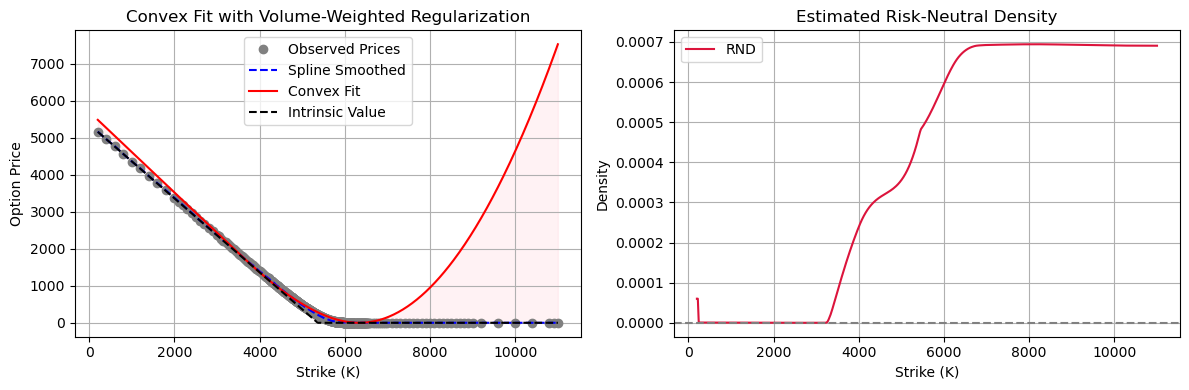

In [51]:
import numpy as np
import cvxpy as cp
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

def compute_numerical_second_derivative(f_vals: np.ndarray, K_vals: np.ndarray) -> np.ndarray:
    d2f = np.zeros_like(f_vals)
    h = K_vals[1] - K_vals[0]  # assumes uniform spacing
    for i in range(1, len(f_vals) - 1):
        d2f[i] = (f_vals[i + 1] - 2 * f_vals[i] + f_vals[i - 1]) / (h ** 2)
    d2f[0] = d2f[1]
    d2f[-1] = d2f[-2]
    return d2f

def fit_spline_then_convex_RND(K: np.ndarray, prices: np.ndarray, S: float, r: float, T: float,
                                volume: np.ndarray = None, lambda_reg: float = 10,
                                num_dense_points: int = 500, save_path: str = None, show_plot: bool = True):
    """
    Full pipeline with volume-weighted fitting:
    - Smooth option prices with B-spline
    - Fit convex + intrinsic-above envelope with curvature regularization
    - Compute RND from final convex curve using central difference

    Parameters:
        K: strike prices (1D array)
        prices: option prices (1D array)
        S: underlying asset price
        r: risk-free rate
        T: time to maturity (in years)
        volume: (optional) volume for each strike, same length as K
        lambda_reg: regularization weight for curvature
        num_dense_points: resolution of smoothing grid
        save_path: optional path to save plots
        show_plot: whether to display the plot

    Returns:
        f_convex_dense: final convex price curve
        RND: estimated risk-neutral density
        K_dense: dense K grid used
    """
    # Step 0: Sort input
    sort_idx = np.argsort(K)
    K = np.array(K)[sort_idx]
    prices = np.array(prices)[sort_idx]
    intrinsic = np.maximum(S - K, 0)
    if volume is not None:
        volume = np.array(volume)[sort_idx]

    # Step 1: B-spline smoothing
    spline = make_interp_spline(K, prices, k=3)
    K_dense = np.linspace(K.min(), K.max(), num_dense_points)
    price_smooth_dense = spline(K_dense)
    intrinsic_dense = np.maximum(S - K_dense, 0)

    # Step 1.5: Generate volume weights if provided
    if volume is not None:
        spline_vol = make_interp_spline(K, volume, k=1)  # linear interpolation for volume
        volume_dense = spline_vol(K_dense)
        weights = np.log1p(volume_dense)
        weights = weights / np.max(weights)
    else:
        weights = np.ones_like(K_dense)

    # Step 2: Optimization
    n = len(K_dense)
    f = cp.Variable(n)

    # Weighted fitting + regularization
    fit_loss = cp.sum_squares(cp.multiply(weights, f - price_smooth_dense))
    curvature_penalty = cp.sum_squares(f[:-2] - 2 * f[1:-1] + f[2:])
    objective = cp.Minimize(fit_loss + lambda_reg * curvature_penalty)

    # Constraints
    constraints = []
    constraints += [f[i - 1] - 2 * f[i] + f[i + 1] >= 0 for i in range(1, n - 1)]  # convexity
    epsilon = 0.0005  # smooth convexity constraint
    for i in range(2, n - 2):
        d2_prev = f[i - 1] - 2 * f[i] + f[i + 1]
        d2_next = f[i] - 2 * f[i + 1] + f[i + 2]
        constraints.append(cp.abs(d2_next - d2_prev) <= epsilon)
    constraints += [f[i] >= intrinsic_dense[i] for i in range(n)]  # intrinsic

    # Solve
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.ECOS)
    f_convex_dense = f.value

    # Step 3: RND
    d2f_dense = compute_numerical_second_derivative(f_convex_dense, K_dense)
    RND = np.exp(-r * T) * d2f_dense

    # Step 4: Visualization
    if show_plot or save_path:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1.plot(K, prices, 'o', color='gray', label='Observed Prices')
        ax1.plot(K_dense, price_smooth_dense, '--', label='Spline Smoothed', color='blue')
        ax1.plot(K_dense, f_convex_dense, label='Convex Fit', color='red')
        ax1.plot(K_dense, intrinsic_dense, '--', label='Intrinsic Value', color='black')
        ax1.fill_between(K_dense, intrinsic_dense, f_convex_dense, color='pink', alpha=0.2)
        ax1.set_title("Convex Fit with Volume-Weighted Regularization")
        ax1.set_xlabel("Strike (K)")
        ax1.set_ylabel("Option Price")
        ax1.grid(True)
        ax1.legend()

        ax2.plot(K_dense, RND, label='RND', color='crimson')
        ax2.axhline(0, linestyle='--', color='gray')
        ax2.set_title("Estimated Risk-Neutral Density")
        ax2.set_xlabel("Strike (K)")
        ax2.set_ylabel("Density")
        ax2.grid(True)
        ax2.legend()

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300)
        if show_plot:
            plt.show()
        else:
            plt.close()

    return f_convex_dense, RND, K_dense

# 샘플 데이터
K = df.index.values
S = call['call_S'].iloc[0]
prices = df['ref_price'].values
volume = df['call_volume'].fillna(1e-6).values
r = call['call_r'].iloc[0]
T = call['call_T'].iloc[0]

f_curve, RND_vals, K_grid = fit_spline_then_convex_RND(
    K=K,
    prices=prices,
    volume=volume,
    S=S,
    r=0.01,
    T=0.25,
    lambda_reg=10,
    save_path="volume_weighted_convex_fit.png",
    show_plot=True
)

It works well if we use the theoretical price provided by Bloomberg, but as you can see in DOTM and DITM prices, their prices tend to well over ask prices. I guess using such prices hinder the realiability, malfeasing the reproducibility of the reality. 

However, if I use either mid price or best estimator of the last price, the estimated probability distribution density exhibits undesirable artifacts, including discontinuities and spurious spikes, even if applying the interpolation method ensuring convexity. 